In [3]:
import json
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("MISTRAL_API_KEY")

# Evaluation of fine-tuned models

## Generation of evaluation set

Evaluation set will be composed of test items created with the same logic as **dataset examples**.
Test items are combinations of : list of genes + list of compounds + matching pathway (=target) and are drawn from KEGG dataset.
I created these random combinations in [testitemgeneration.py](tetestitemgeneration.py). I made 200 test items.


## Interrogation of the models with the test dataset

To be fair with the different models, a system prompt is added, in order to set the following guidelines :
* Find the altered pathway
* <200 words

Following models were used :

I had the models pass this test using [evaluation.py](evaluation.py) script. Below is an example of how the results look like.

In [4]:
entries = []
with open("test/test_pass.jsonl", 'r') as infile:
    for line in infile:
        try:
            entry = json.loads(line)
            entries.append(entry)
        except json.JSONDecodeError:
            print(f"Ignoring invalid JSON: {line}")
len(entries)

200

In [5]:
entries[0]

{'input': {'genes': ['PCCA', 'PGAM1'],
  'cpd': ['Tetrahydrosarcinapterin',
   'D-Xylulose 5-phosphate',
   'CO2',
   'L-erythro-3-Methylmalyl-CoA',
   '2-Phosphoglycolate',
   '5-Formyl-5,6,7,8-tetrahydromethanopterin',
   'L-Serine',
   'D-Glucono-1,5-lactone 6-phosphate',
   'Glycolate',
   'D-Glucono-1,5-lactone',
   'D-Fructose 6-phosphate',
   'D-Gluconic acid',
   'Glycerone',
   'D-Glycerate',
   '4-Hydroxybutyryl-CoA']},
 'target': 'Carbon metabolism',
 'output': {'open-mistral-7b': 'The altered pathway involves the genes PCCA and PGAM1, which are associated with the glyoxylate cycle and the glycolysis pathway, respectively.\n\nThe glyoxylate cycle is a metabolic pathway that occurs in some microorganisms, plants, and animals. It allows these organisms to convert acetyl-CoA derived from fatty acids into glucose-6-phosphate, providing a means of glucose production when glucose is limited. The cycle involves two key enzymes, ISOCITRATE LYASE (ICL) and MALATE SYNTHASE (MLS), whic

## Scoring of the models : LLM as a judge

In order to score models performance on test dataset, I used mistral-large-latest model together with a list of metrics and rubrics. Large model was instructed to send back a json file containing the scores. Following metrics were used :

Scoring was performed using [scoring.py](scoring.py) script.

## Visualisation of the results

In [7]:
# Initialize a list to store the data
data_list = []

# Read the JSONL file
with open('test/test_eval.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        for llm, scores in data.items():
            scores['LLM'] = llm
            data_list.append(scores)

# Create the DataFrame
df = pd.DataFrame(data_list)

# Reorder columns
df = df[['LLM', 'accuracy', 'informativity', 'format']]

# Display the DataFrame
print(df)

       LLM  accuracy  informativity  format
0    LLM 1         2              3       2
1    LLM 2         2              3       3
2    LLM 3         2              3       3
3    LLM 4         2              3       3
4    LLM 1         2              3       3
..     ...       ...            ...     ...
795  LLM 4         3              3       3
796  LLM 1         2              3       2
797  LLM 2         2              3       3
798  LLM 3         2              3       3
799  LLM 4         2              3       3

[800 rows x 4 columns]


In [8]:
df = df.replace('LLM 1', 'mistral-7b')
df = df.replace('LLM 2', 'fine-tune-1')
df = df.replace('LLM 3', 'fine-tune-2')
df = df.replace('LLM 4', 'mistral-small')

In [9]:
sums = df.groupby(by=df["LLM"]).sum()
sums = sums.reset_index()
print(sums)

             LLM  accuracy  informativity  format
0    fine-tune-1       565            561     595
1    fine-tune-2       553            579     598
2     mistral-7b       480            529     524
3  mistral-small       537            540     585


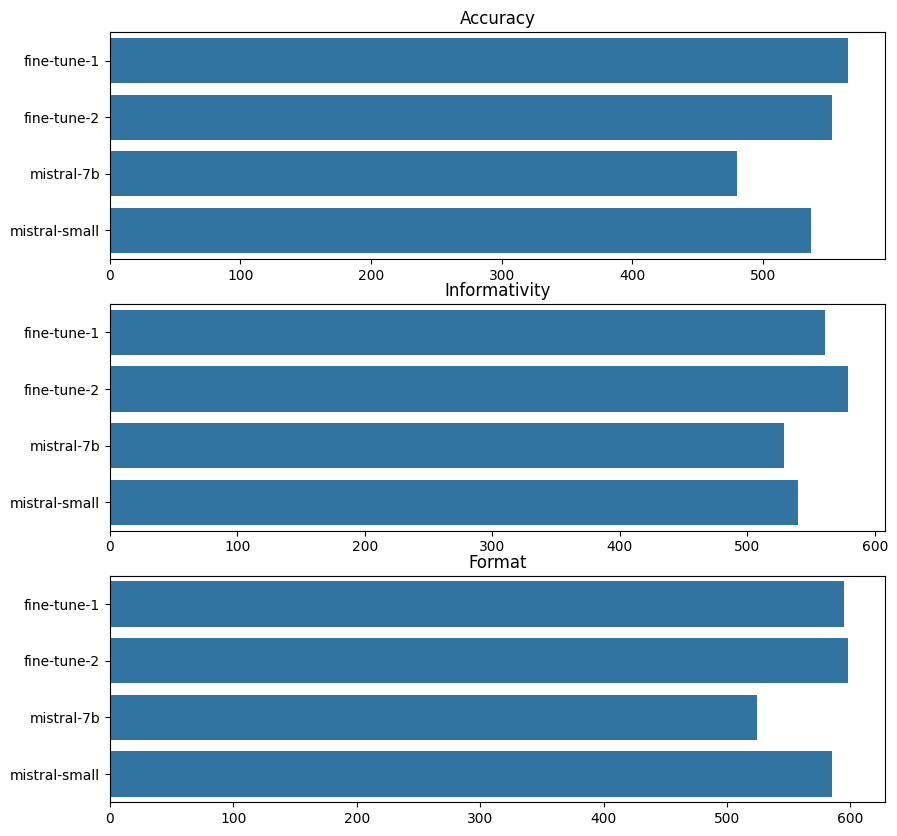

In [10]:
plt.figure(figsize=(10, 10))

metrics = ['accuracy', 'informativity', 'format']

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i+1)
    sns.barplot(x=metric, y='LLM', data=sums, legend=False)
    plt.title(f'{metric.capitalize()}')
    plt.xlabel('')
    plt.ylabel('')

plt.savefig('metrics_comparison.png', dpi=300)
plt.show()

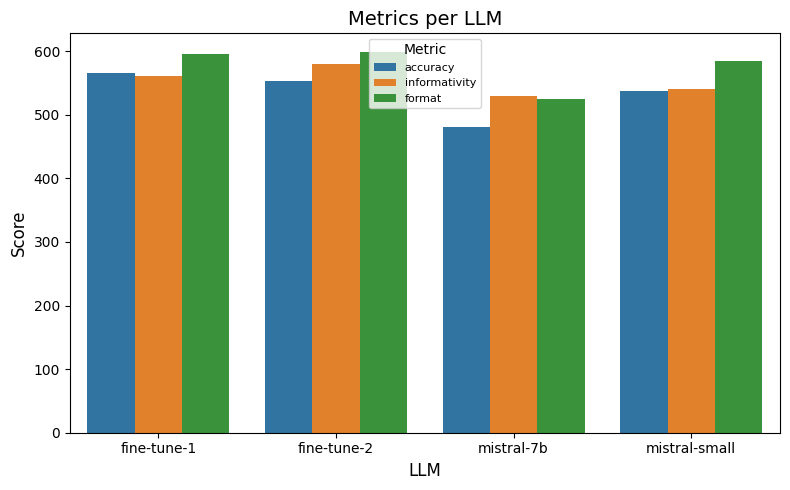

In [11]:
plt.figure(figsize=(8, 5))
sums_melted = sums.melt(id_vars=['LLM'], var_name='Metric', value_name='Score')
sns.barplot(x='LLM', y='Score', hue='Metric', data=sums_melted)
plt.title('Metrics per LLM', fontsize=14)
plt.xlabel('LLM', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Metric', title_fontsize='10', fontsize='8')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('combined_graph.png', dpi=300, bbox_inches='tight')
plt.show()

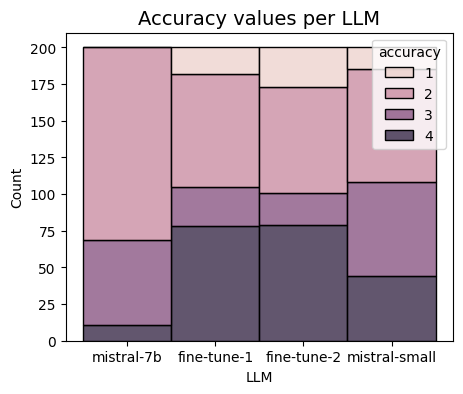

In [12]:
plt.figure(figsize=(5, 4))
sns.histplot(df,
    x="LLM", hue="accuracy",
    multiple="stack")
plt.title('Accuracy values per LLM', fontsize=14)
plt.savefig('accuracy_values.png', dpi=300, bbox_inches='tight')
plt.show()

The fine tuned model clearly have more "exact match" answers than original model mistral-7b.
However, they also seem to have more scores of 1, associated with an answer not containing a metabolic pathway.
I then checked the answers corresponding to these scores of 1 (see below). 
It seems that they mostly mention metabolic pathway, and sometimes it is even the right metabolic pathway.
Likely there was a scoring problem with these answers, highlighting a need for a manual scoring.
Considering this represents 800 answers to score, it would be interesting to first implement a scoring interface (future perspective).

In [29]:
modelmap = {'mistral-7b':'open-mistral-7b',
            'fine-tune-1':'ft:open-mistral-7b:5aebfd1c:20240627:e63dc09f',
            'fine-tune-2':'ft:open-mistral-7b:5aebfd1c:20240628:de14ae4a',
            'mistral-small':'mistral-small-latest'}

for i in df.loc[(df['accuracy'] == 1) & (df['LLM'] == 'fine-tune-2')].index:
    model = df.loc[i, 'LLM']
    modelcode = modelmap[model]
    answer = entries[i//4]["output"][modelcode]
    print(f'\nLine {i//4}, target pathway {entries[i//4]["target"]}, model {model}:')
    print(answer)


Line 4, target pathway Valine, leucine and isoleucine degradation, model fine-tune-2:
The altered pathway identified in this experiment is the Butanoate metabolism. This is supported by the alteration of genes associated with this pathway, such as AACS and HMGCS1, which are involved in the biosynthesis of fatty acids. Additionally, the presence of compounds like 3-Methyl-1-hydroxybutyl-ThPP and L-Leucine, which are intermediates in this pathway, further strengthens this conclusion. The metabolites 2-Methylpropanoyl-CoA and 2-Methylbut-2-enoyl-CoA are also indicative of the involvement of this pathway, as they are intermediates in the butanoate metabolism. The compound [Dihydrolipoyllysine-residue (2-methylpropanoyl)transferase] S-(3-methylbutanoyl)dihydrolipoyllysine also suggests the involvement of this pathway, as it is a key enzyme in the Butanoate metabolism. Therefore, the Butanoate metabolism pathway is the likely altered pathway.

Line 9, target pathway Mucin type O-glycan bios